In [ ]:
import requests
import pandas as pd
import time

API_KEY = "NOAqiPFAbaa1z4heJnaPpDhjbCxopezbJn2MApdx"
SEARCH_URL = "https://api.nal.usda.gov/fdc/v1/foods/search"

nutrient_map = {
    "Energy": "calories",
    "Protein": "protein_g",
    "Carbohydrate, by difference": "carbs_g",
    "Total lipid (fat)": "fat_g",
    "Fiber, total dietary": "fiber_g",
    "Sugars, total": "sugar_g"
}

all_foods = []
page = 1
max_rows = 50000  # target
collected = 0

while collected < max_rows:
    print(f"Fetching page {page}...")
    params = {
        "api_key": API_KEY,
        "query": "*",
        "pageSize": 200,
        "pageNumber": page
    }
    resp = requests.get(SEARCH_URL, params=params).json()
    foods = resp.get("foods", [])

    if not foods:
        break

    for f in foods:
        nutrients = {v: None for v in nutrient_map.values()}
        for n in f.get("foodNutrients", []):
            name = n.get("nutrientName")
            if name in nutrient_map:
                nutrients[nutrient_map[name]] = n.get("value")

        all_foods.append({
            "fdcId": f.get("fdcId"),
            "description": f.get("description"),
            "dataType": f.get("dataType"),
            **nutrients
        })

    collected += len(foods)
    page += 1
    time.sleep(0.2)  # avoid rate-limit

df = pd.DataFrame(all_foods)
df.to_csv("usda_foods_50k.csv", index=False)

print(f"✅ Collected {len(df)} foods with macros!")


Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Fetching page 6...
Fetching page 7...
Fetching page 8...
Fetching page 9...
Fetching page 10...
Fetching page 11...
Fetching page 12...
Fetching page 13...
Fetching page 14...
Fetching page 15...
Fetching page 16...
Fetching page 17...
Fetching page 18...
Fetching page 19...
Fetching page 20...
Fetching page 21...
Fetching page 22...
Fetching page 23...
Fetching page 24...
Fetching page 25...
Fetching page 26...
Fetching page 27...
Fetching page 28...
Fetching page 29...
Fetching page 30...
Fetching page 31...
Fetching page 32...
Fetching page 33...
Fetching page 34...
Fetching page 35...
Fetching page 36...
Fetching page 37...
Fetching page 38...
Fetching page 39...
Fetching page 40...
Fetching page 41...
Fetching page 42...
Fetching page 43...
Fetching page 44...
Fetching page 45...
Fetching page 46...
Fetching page 47...
Fetching page 48...
Fetching page 49...
Fetching page 50...
Fetching 

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Data Loading
# ----------------------------
df = pd.read_csv('usda_foods_20k.csv')

# Basic summary of the DataFrame
print(df.info())        # Overview of data types, non-null counts
print(df.describe())    # Statistical summary of numeric columns
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fdcId        20000 non-null  int64  
 1   description  20000 non-null  object 
 2   dataType     20000 non-null  object 
 3   calories     19597 non-null  float64
 4   protein_g    19834 non-null  float64
 5   carbs_g      19702 non-null  float64
 6   fat_g        19818 non-null  float64
 7   fiber_g      17448 non-null  float64
 8   sugar_g      0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.4+ MB
None
              fdcId      calories     protein_g       carbs_g         fat_g  \
count  2.000000e+04  19597.000000  19834.000000  19702.000000  19818.000000   
mean   1.529923e+06    322.475665      8.956240     20.936355     10.152031   
std    1.146135e+06    443.812124      9.758808     38.855029     18.226964   
min    1.675120e+05      0.000000      0.000000

In [ ]:
# ----------------------------
# 2. Initial Exploration
# ----------------------------
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:\n", df.isna().sum())

Shape: (20000, 9)

Columns: ['fdcId', 'description', 'dataType', 'calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g']

Missing values:
 fdcId              0
description        0
dataType           0
calories         403
protein_g        166
carbs_g          298
fat_g            182
fiber_g         2552
sugar_g        20000
dtype: int64


In [ ]:
# ----------------------------
# 3. Handle missing values
# ----------------------------
df = df.drop(columns=["sugar_g"])

# Drop rows where description contains 'raw' (case-insensitive)
df = df[~df['description'].str.contains("raw", case=False, na=False)]

# Strategy: Fill with median (robust to skewness)
median_cols = ['protein_g','carbs_g','fat_g','fiber_g']
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

# Only apply formula where calories are missing
mask = df["calories"].isna()

df.loc[mask, "calories"] = (
    4 * df.loc[mask, "protein_g"].fillna(0) +
    4 * df.loc[mask, "carbs_g"].fillna(0) +
    9 * df.loc[mask, "fat_g"].fillna(0)
)



Skewness of numerical features:
calories      4.405432
protein_g     2.001367
carbs_g      44.235660
fat_g         3.489129
fiber_g      59.674809
dtype: float64


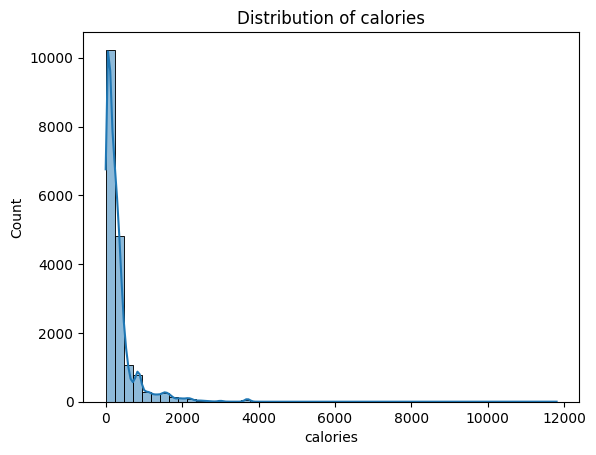

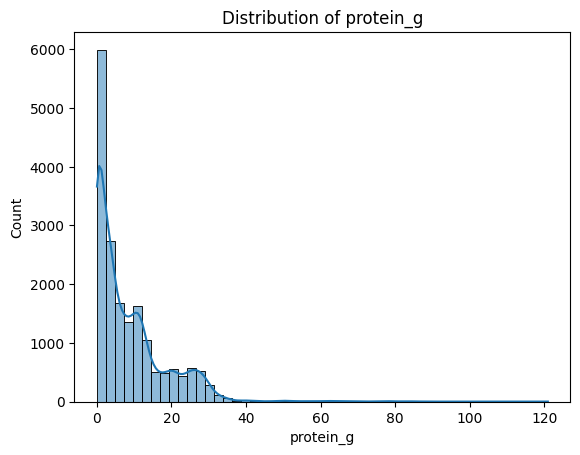

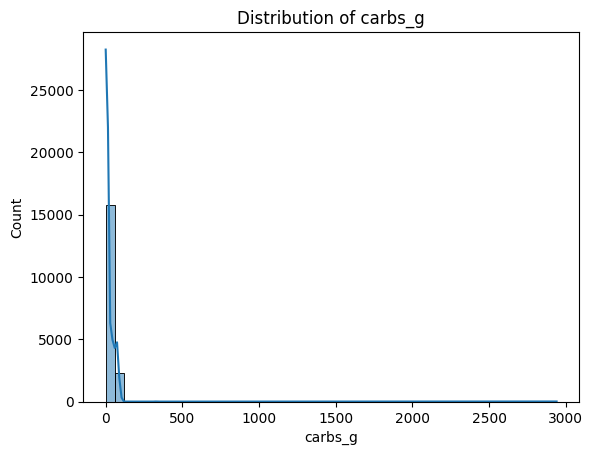

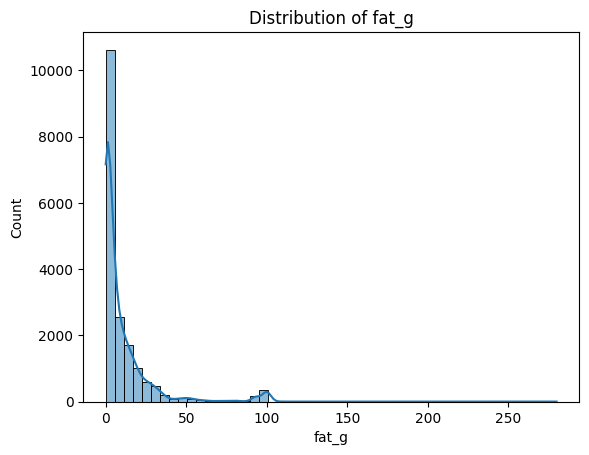

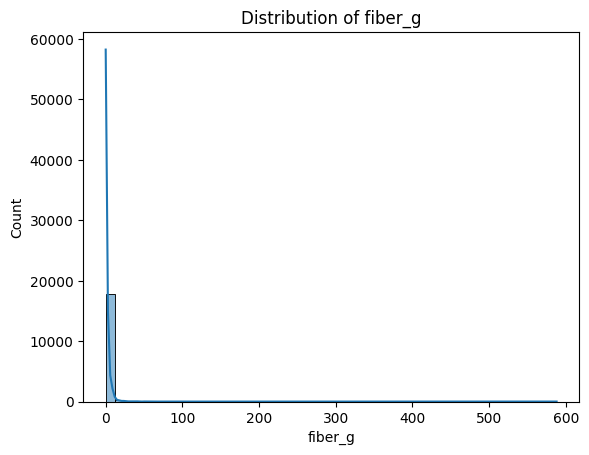


✅ Cleaned + engineered dataset ready!
     fdcId                        description   dataType  calories  protein_g  \
3   170683             Amaranth grain, cooked  SR Legacy -0.489916  -0.491801   
4   170682           Amaranth grain, uncooked  SR Legacy  0.110612   0.518868   
33  170283                     Barley, hulled  SR Legacy  0.072661   0.405426   
34  172232                       Basil, fresh  SR Legacy -0.507775  -0.558835   
57  169793  Bear, black, meat (Alaska Native)  SR Legacy  0.731232   1.189209   

     carbs_g     fat_g   fiber_g  protein_ratio  carb_ratio  fat_ratio  \
3  -0.078297 -0.472405  0.031662       0.157807    0.776578   0.065615   
4   1.092238 -0.181219  0.827405       0.158471    0.759730   0.081799   
33  1.301172 -0.433866  2.661074       0.141563    0.832390   0.026048   
34 -0.482321 -0.522720 -0.054831       0.489130    0.411491   0.099379   
57 -0.549029 -0.112704 -0.193221       0.707746    0.000000   0.292254   

    cal_per_protein  cal_per_

In [ ]:
num_cols = ['calories','protein_g','carbs_g','fat_g','fiber_g']

# ----------------------------
# 5. Feature Engineering
# ----------------------------
# Macro ratios
df['protein_ratio'] = df['protein_g'] / (df['protein_g']+df['carbs_g']+df['fat_g'] + 1e-6)
df['carb_ratio']    = df['carbs_g']   / (df['protein_g']+df['carbs_g']+df['fat_g'] + 1e-6)
df['fat_ratio']     = df['fat_g']     / (df['protein_g']+df['carbs_g']+df['fat_g'] + 1e-6)

# Calorie density per gram (approx)
df['cal_per_protein'] = df['calories'] / (df['protein_g'] + 1e-6)
df['cal_per_carb']    = df['calories'] / (df['carbs_g'] + 1e-6)
df['cal_per_fat']     = df['calories'] / (df['fat_g'] + 1e-6)

# Macro balance score (how evenly macros are distributed)
df['macro_balance'] = 1 - (abs(df['protein_ratio']-1/3) + abs(df['carb_ratio']-1/3) + abs(df['fat_ratio']-1/3))

# ----------------------------
# 6. Skewness Check
# ----------------------------
print("\nSkewness of numerical features:")
print(df[num_cols].skew())

# Plot distributions
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"Distribution of {col}")
    plt.show()

# ----------------------------
# 7. Normalization
# ----------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_cols = ['calories','protein_g','carbs_g','fat_g','fiber_g']
df_scaled = df.copy()
df_scaled[scaled_cols] = scaler.fit_transform(df[scaled_cols])

print("\n✅ Cleaned + engineered dataset ready!")
print(df_scaled.head())

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
features = ['calories','protein_g','carbs_g','fat_g','fiber_g']
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

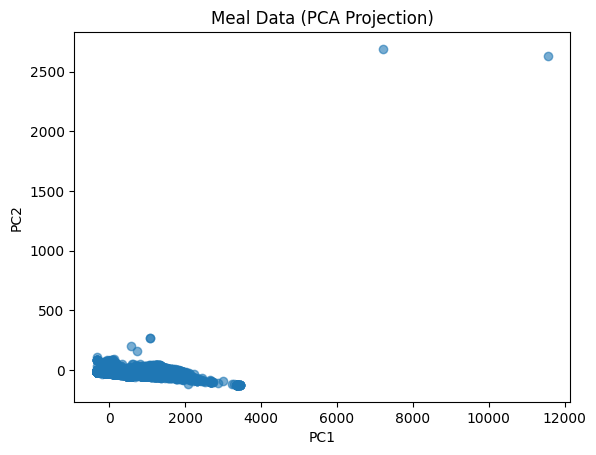

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Meal Data (PCA Projection)")
plt.show()


In [ ]:
def remove_outliers_iqr(df, factor=1.5):
    df_clean = df.copy()
    num_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in num_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

df_clean = remove_outliers_iqr(df, factor=1.5)


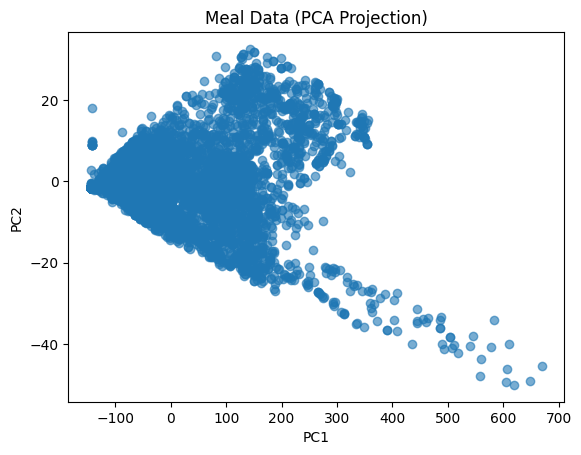

In [ ]:
from sklearn.decomposition import PCA
X = df_clean[features]
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Meal Data (PCA Projection)")
plt.show()


In [ ]:
X.to_csv("meal_features_cleaned.csv", index=False)
